In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

# Chuẩn bị dữ liệu
data = pd.read_csv('ACB-Historical-Data_Group 9.csv', index_col='Date', parse_dates=True)

# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'], data['Open'], data['High'], data['Low'] = [data[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
data['Change %'] = data['Change %'].apply(convert_change_to_number)
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

data.reset_index(drop=True, inplace=True)
data.head(10)

,Price,Open,High,Low,Vol.,Change %
0,11361.0,11285.2,11398.8,11171.6,3910000,0.0101
1,11512.4,11361.0,11550.3,11323.1,8240000,0.0133
2,11474.6,11512.4,11626.0,11398.8,6510000,-0.0033
3,11474.6,11436.7,11512.4,11361.0,3110000,0.0000
4,11550.3,11512.4,11626.0,11474.6,8720000,0.0066
5,11474.6,11512.4,11588.2,11436.7,3740000,-0.0066
6,11512.4,11474.6,11588.2,11436.7,2730000,0.0033
7,11701.8,11550.3,11701.8,11474.6,6610000,0.0165
8,11891.1,11777.5,12004.7,11701.8,14450000,0.0162
9,11929.0,11891.1,12118.4,11853.3,6160000,0.0032


In [2]:
df1=data.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# chuyển mảng giá trị sang matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Build LSTM modal

# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.1963 - val_loss: 0.0336
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0186 - val_loss: 0.0064
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0101 - val_loss: 0.0055
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0071 - val_loss: 0.0056
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0060 - val_loss: 0.0072
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0042 - val_loss: 0.0056
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [14]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 794.1741961828975
Testing RMSE: 517.070217337867


In [15]:
from sklearn.metrics import mean_absolute_error
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 673.3507812499998
Testing MAE: 365.5133419552367


In [16]:
from sklearn.metrics import mean_absolute_percentage_error

In [17]:
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 0.024738201056680315
Testing MAPE: 0.015284482500085511


In [24]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[40:].reshape(1, -1)
x_input.shape
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
from numpy import array
lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) >= n_steps:
        # print(temp_input)
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, len(x_input[0]), 1))  # Reshape based on actual input length
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, len(x_input[0]), 1))  # Reshape based on actual input length
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

[0.8520957]
87
[0.8520957]
88
[0.8520957]
89
[0.8520957]
90
[0.8520957]
91
[0.8520957]
92
[0.8520957]
93
[0.8520957]
94
[0.8520957]
95
[0.8520957]
96
[0.8520957]
97
[0.8520957]
98
[0.8520957]
99
[0.8520957]
100
14 day input [0.59207108 0.58049535 0.58512564 0.59438623 0.62679829 0.61522256
 0.622168   0.6175377  0.64994976 0.63837403 0.63142858 0.63374373
 0.64531947 0.67078609 0.67310123 0.64531947 0.63605888 0.64068917
 0.64531947 0.622168   0.61522256 0.60596197 0.60827711 0.61522256
 0.61059226 0.61059226 0.62679829 0.61985285 0.62679829 0.63142858
 0.63142858 0.63142858 0.63605888 0.62679829 0.63605888 0.64763461
 0.64994976 0.6615255  0.66847094 0.67078609 0.66847094 0.67541638
 0.67078609 0.67310123 0.69393756 0.700883   0.72634961 0.75181623
 0.76570712 0.77265256 0.76802226 0.75181623 0.76339197 0.76339197
 0.78885859 0.76570712 0.77033741 0.77033741 0.779598   0.79580403
 0.81201006 0.80043432 0.78885859 0.78885859 0.81201006 0.79580403
 0.79580403 0.78654344 0.79811917 0.809

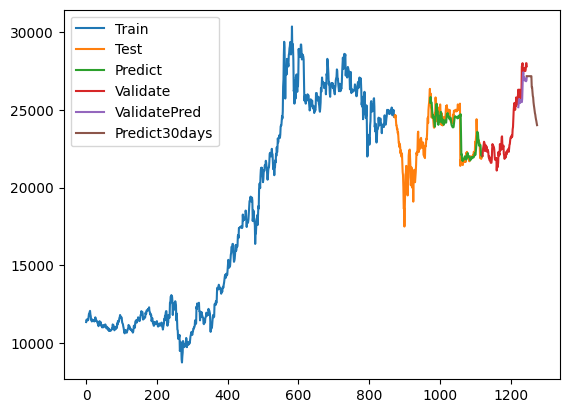

In [26]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [24]:
scaler.inverse_transform(lst_output)

array([[1942.30588567],
       [1934.00924157],
       [1898.71408367],
       [1881.90078634],
       [1860.19694274],
       [1845.34520634],
       [1830.51825161],
       [1821.62783856],
       [1810.38327068],
       [1803.64088109],
       [1794.74311179],
       [1789.10186334],
       [1782.03454686],
       [1776.53875381],
       [1769.37997989],
       [1763.78109507],
       [1757.26434916],
       [1752.21488712],
       [1746.71179   ],
       [1742.05403495],
       [1737.19427012],
       [1732.71776043],
       [1728.07889163],
       [1723.90195326],
       [1719.53437859],
       [1715.5853273 ],
       [1711.50062894],
       [1707.13988879],
       [1702.86335418],
       [1698.67467712]])